# Top overlapping annotations by weighted sum for saur cohort

In [1]:
import pandas as pd


pd.set_option("display.max_columns", None) # show all cols
pd.set_option('display.max_colwidth', None) # show full width of showing cols
pd.set_option("display.expand_frame_repr", False) # print cols side by side as it's supposed to be

## Read token information from bed files

In [2]:
import os
import pandas as pd
from pathlib import Path


bedDir = Path(os.environ['GENOMICS_DATA_BASE'], 'genome_nlp_tokens', 'bed_files', 'SAUR')

bedDfList = []
for bedFile in os.listdir(bedDir):
    tubeid = bedFile.split('.')[0].split('_')[0]
    tokensDf = pd.read_csv(Path(bedDir, bedFile), sep='\t', names=['contig_id', 'start_position', 'end_position', 'tokens', 'score'])
    tokensDf['tube_id'] = tubeid
    bedDfList.append(tokensDf)

bedDf = pd.concat(bedDfList, ignore_index=True)
bedDf

,contig_id,start_position,end_position,tokens,score,tube_id
0,1,0,6,TTTTCTT,0.000064,ALF22G140
1,1,7,9,ACC,-0.000395,ALF22G140
2,1,10,13,GACA,0.001573,ALF22G140
3,1,14,18,AGAAT,-0.000986,ALF22G140
4,1,19,25,TAATTAT,0.000795,ALF22G140
...,...,...,...,...,...,...
176721937,5,181665,181667,CGG,-0.002273,AH21C044
176721938,5,181668,181673,CTCATC,-0.001735,AH21C044
176721939,5,181674,181676,GCA,-0.003468,AH21C044
176721940,5,181677,181680,TCCA,-0.000228,AH21C044


<Axes: >

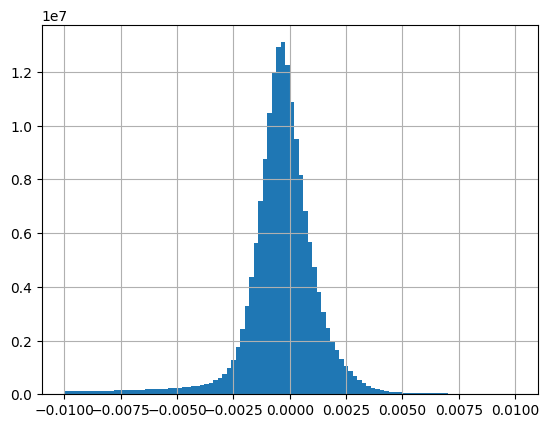

In [3]:
bedDf[(bedDf.score > -0.01) & (bedDf.score < 0.01)].score.hist(bins=100)

In [4]:
bedDf['token_length'] = bedDf.tokens.apply(lambda x: len(x))
bedDf

,contig_id,start_position,end_position,tokens,score,tube_id,token_length
0,1,0,6,TTTTCTT,0.000064,ALF22G140,7
1,1,7,9,ACC,-0.000395,ALF22G140,3
2,1,10,13,GACA,0.001573,ALF22G140,4
3,1,14,18,AGAAT,-0.000986,ALF22G140,5
4,1,19,25,TAATTAT,0.000795,ALF22G140,7
...,...,...,...,...,...,...,...
176721937,5,181665,181667,CGG,-0.002273,AH21C044,3
176721938,5,181668,181673,CTCATC,-0.001735,AH21C044,6
176721939,5,181674,181676,GCA,-0.003468,AH21C044,3
176721940,5,181677,181680,TCCA,-0.000228,AH21C044,4


In [5]:
len(bedDf.tokens.unique())

3894

In [6]:
highscoreCutoff = bedDf.score.mean() + 3 * bedDf.score.std()
highscoreCutoff

np.float64(0.012133979502852287)

In [7]:
highscoreDf = bedDf[bedDf.score > highscoreCutoff]
highscoreDf

,contig_id,start_position,end_position,tokens,score,tube_id,token_length
13703,1,75447,75454,TATACTTT,0.013623,ALF22G140,8
13723,1,75557,75561,AATGA,0.014487,ALF22G140,5
13725,1,75567,75572,CCTGAG,0.015546,ALF22G140,6
13753,1,75724,75731,CTGCACCC,0.018303,ALF22G140,8
13785,1,75898,75902,GAGCA,0.018827,ALF22G140,5
...,...,...,...,...,...,...,...
176698433,5,50635,50641,AATGTTT,0.016897,AH21C044,7
176698449,5,50725,50728,ACTG,0.020198,AH21C044,4
176698513,5,51074,51079,GGCGCG,0.015019,AH21C044,6
176698639,5,51802,51807,AAATAT,0.013009,AH21C044,6


In [8]:
len(highscoreDf.tokens.unique())

1991

In [9]:
highscoreDf.shape

(286987, 7)

<Axes: >

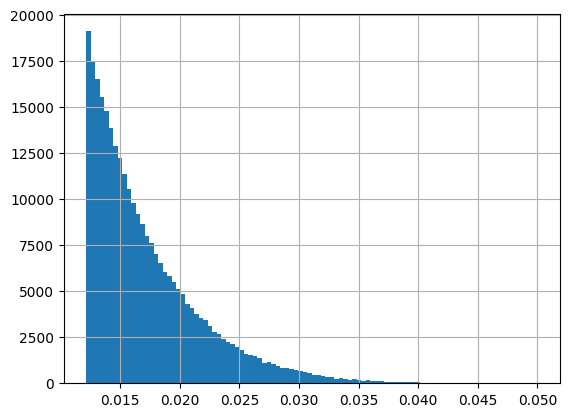

In [10]:
highscoreDf[(highscoreDf.score < 0.05)].score.hist(bins=100)

In [11]:
highscoreDf.token_length.value_counts()

token_length
6     104579
5      75597
7      51246
4      33151
8      16706
3       2680
9       1348
10       798
2        738
13        73
1         68
11         3
Name: count, dtype: int64

<Axes: xlabel='token_length', ylabel='Count'>

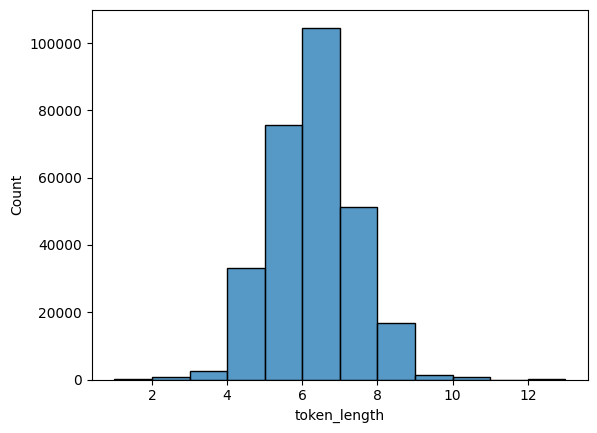

In [12]:
import seaborn as sns

sns.histplot(highscoreDf.token_length, binwidth=1)

## Read bed files containing overlapping tokens and attribution scores

In [13]:
from tqdm import tqdm

import os
import pandas as pd
from pathlib import Path


annotationOverlappingFilesDir = Path(os.environ['GENOMICS_DATA_BASE'], 'genome_nlp_tokens', 'overlapping_with_annotations', 'SAUR')

annotationOverlappingDfList = []
for annotationOverlappingFile in tqdm(os.listdir(annotationOverlappingFilesDir)):
    df = pd.read_csv(Path(annotationOverlappingFilesDir, annotationOverlappingFile), sep='\t', names=['contig_id', 'start_position', 'end_position', 'tokens', 'score', 'feature_type', 'id', 'name', 'gene', 'atributes'])
    df = df[df.feature_type.isin(['CDS', 'ncRNA', 'oriC', 'regulatory_region', 'oriT'])]
    df['tube_code'] = [annotationOverlappingFile.split('_')[0]]*df.shape[0]
    df = df[df.tokens.apply(lambda x: (len(x) >= 5))].reset_index()
    df['gene'] = df.gene.str.lower()
    annotationOverlappingDfList.append(df)
annotationOverlappingDf = pd.concat(annotationOverlappingDfList, ignore_index=True)
annotationOverlappingDf = annotationOverlappingDf.drop_duplicates()
annotationOverlappingDf

  0%|          | 0/515 [00:00<?, ?it/s]

 13%|█▎        | 66/515 [01:30<09:56,  1.33s/it]/tmp/ipykernel_5561/1662500944.py:12: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(Path(annotationOverlappingFilesDir, annotationOverlappingFile), sep='\t', names=['contig_id', 'start_position', 'end_position', 'tokens', 'score', 'feature_type', 'id', 'name', 'gene', 'atributes'])
 24%|██▎       | 122/515 [02:50<07:36,  1.16s/it]/tmp/ipykernel_5561/1662500944.py:12: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(Path(annotationOverlappingFilesDir, annotationOverlappingFile), sep='\t', names=['contig_id', 'start_position', 'end_position', 'tokens', 'score', 'feature_type', 'id', 'name', 'gene', 'atributes'])
 33%|███▎      | 172/515 [04:01<07:27,  1.30s/it]/tmp/ipykernel_5561/1662500944.py:12: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df

,index,contig_id,start_position,end_position,tokens,score,feature_type,id,name,gene,atributes,tube_code
0,3,1,138,145,AAAGTAAA,0.009005,CDS,OILJNO_00005,acyl carrier protein,acpp,"ID=OILJNO_00005;Name=acyl carrier protein;locus_tag=OILJNO_00005;product=acyl carrier protein;Dbxref=GO:0000036,GO:0005737,GO:0046677,RefSeq:WP_000426914.1,SO:0001217,UniParc:UPI0000125385,UniRef:UniRef100_A7X1J8,UniRef:UniRef50_A7X1J8,UniRef:UniRef90_A7X1J8;gene=acpP",AH20I016
1,4,1,146,151,AGATAT,-0.010377,CDS,OILJNO_00005,acyl carrier protein,acpp,"ID=OILJNO_00005;Name=acyl carrier protein;locus_tag=OILJNO_00005;product=acyl carrier protein;Dbxref=GO:0000036,GO:0005737,GO:0046677,RefSeq:WP_000426914.1,SO:0001217,UniParc:UPI0000125385,UniRef:UniRef100_A7X1J8,UniRef:UniRef50_A7X1J8,UniRef:UniRef90_A7X1J8;gene=acpP",AH20I016
2,6,1,156,160,GTTGA,-0.016608,CDS,OILJNO_00005,acyl carrier protein,acpp,"ID=OILJNO_00005;Name=acyl carrier protein;locus_tag=OILJNO_00005;product=acyl carrier protein;Dbxref=GO:0000036,GO:0005737,GO:0046677,RefSeq:WP_000426914.1,SO:0001217,UniParc:UPI0000125385,UniRef:UniRef100_A7X1J8,UniRef:UniRef50_A7X1J8,UniRef:UniRef90_A7X1J8;gene=acpP",AH20I016
3,8,1,164,169,TTTAGG,-0.011910,CDS,OILJNO_00005,acyl carrier protein,acpp,"ID=OILJNO_00005;Name=acyl carrier protein;locus_tag=OILJNO_00005;product=acyl carrier protein;Dbxref=GO:0000036,GO:0005737,GO:0046677,RefSeq:WP_000426914.1,SO:0001217,UniParc:UPI0000125385,UniRef:UniRef100_A7X1J8,UniRef:UniRef50_A7X1J8,UniRef:UniRef90_A7X1J8;gene=acpP",AH20I016
4,9,1,170,175,TGTAGA,0.002626,CDS,OILJNO_00005,acyl carrier protein,acpp,"ID=OILJNO_00005;Name=acyl carrier protein;locus_tag=OILJNO_00005;product=acyl carrier protein;Dbxref=GO:0000036,GO:0005737,GO:0046677,RefSeq:WP_000426914.1,SO:0001217,UniParc:UPI0000125385,UniRef:UniRef100_A7X1J8,UniRef:UniRef50_A7X1J8,UniRef:UniRef90_A7X1J8;gene=acpP",AH20I016
...,...,...,...,...,...,...,...,...,...,...,...,...
110816017,337313,5,205763,205769,ATGATAT,0.002546,CDS,KKIOAG_10525,Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase,pulo,"ID=KKIOAG_10525;Name=Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase;locus_tag=KKIOAG_10525;product=Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase;Dbxref=COG:COG1989,COG:NU,RefSeq:WP_000261111.1,SO:0001217,UniParc:UPI0001DDA595,UniRef:UniRef100_A0A0D1JKS9,UniRef:UniRef50_A0A0D1JKS9,UniRef:UniRef90_A0A0D1JKS9;gene=pulO",AH21K020
110816018,337314,5,205770,205775,CCATCA,0.000022,CDS,KKIOAG_10525,Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase,pulo,"ID=KKIOAG_10525;Name=Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase;locus_tag=KKIOAG_10525;product=Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase;Dbxref=COG:COG1989,COG:NU,RefSeq:WP_000261111.1,SO:0001217,UniParc:UPI0001DDA595,UniRef:UniRef100_A0A0D1JKS9,UniRef:UniRef50_A0A0D1JKS9,UniRef:UniRef90_A0A0D1JKS9;gene=pulO",AH21K020
110816019,337315,5,205776,205781,ATTTTT,-0.002056,CDS,KKIOAG_10525,Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase,pulo,"ID=KKIOAG_10525;Name=Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase;locus_tag=KKIOAG_10525;product=Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase;Dbxref=COG:COG1989,COG:NU,RefSeq:WP_000261111.1,SO:0001217,UniParc:UPI0001DDA595,UniRef:UniRef100_A0A0D1JKS9,UniRef:UniRef50_A0A0D1JKS9,UniRef:UniRef90_A0A0D1JKS9;gene=pulO",AH21K020
110816020,337316,5,205782,205787,AGGAGG,0.000008,CDS,KKIOAG_10525,Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase,pulo,"ID=KKIOAG_10525;Name=Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase;locus_tag=KKIOAG_10525;product=Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase;Dbxref=COG:COG1989,COG:NU,RefSeq:WP_000261111.1,SO:0001217,UniParc:U

In [14]:
from tqdm import tqdm


amrfinderDir = Path(os.environ['GENOMICS_DATA_BASE'], 'amrfinder')

amrOverlappingDfList = []
for tubeId in tqdm(bedDf.tube_id.unique()):
    tubeidHighscoreDf = highscoreDf[highscoreDf.tube_id == tubeId]
    amrfinderFile = Path(amrfinderDir, tubeId + '_amr_results.txt')
    if(amrfinderFile.exists()):
        amrfinderDf = pd.read_csv(amrfinderFile, sep='\t')
        mergedDf = tubeidHighscoreDf.merge(
            amrfinderDf,
            how='inner',
            left_on = ['contig_id'],
            right_on = ['Contig id'],
        )
        mergedDf['tube_code'] = tubeId
        tubeidOverlappingDf = mergedDf[(mergedDf.start_position >= mergedDf.Start) & (mergedDf.end_position <= mergedDf.Stop)]
        amrOverlappingDfList.append(tubeidOverlappingDf)

amrOverlappingDf = pd.concat(amrOverlappingDfList, ignore_index=True)
amrOverlappingDf

100%|██████████| 557/557 [00:09<00:00, 60.24it/s]


,contig_id,start_position,end_position,tokens,score,tube_id,token_length,Protein identifier,Contig id,Start,Stop,Strand,Gene symbol,Sequence name,Scope,Element type,Element subtype,Class,Subclass,Method,Target length,Reference sequence length,% Coverage of reference sequence,% Identity to reference sequence,Alignment length,Accession of closest sequence,Name of closest sequence,HMM id,HMM description,tube_code
0,3,92632,92637,TGAAGT,0.016457,ALF22G140,6,NaN,3,92622,93371,+,sel26,staphylococcal enterotoxin type 26,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,250,250,100.0,94.80,250,KAG18833.1,staphylococcal enterotoxin type 26,NaN,NaN,ALF22G140
1,3,92734,92739,TAAACT,0.012154,ALF22G140,6,NaN,3,92622,93371,+,sel26,staphylococcal enterotoxin type 26,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,250,250,100.0,94.80,250,KAG18833.1,staphylococcal enterotoxin type 26,NaN,NaN,ALF22G140
2,3,93110,93114,AAAAC,0.013360,ALF22G140,5,NaN,3,92622,93371,+,sel26,staphylococcal enterotoxin type 26,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,250,250,100.0,94.80,250,KAG18833.1,staphylococcal enterotoxin type 26,NaN,NaN,ALF22G140
3,3,93281,93285,GAGTA,0.012412,ALF22G140,5,NaN,3,92622,93371,+,sel26,staphylococcal enterotoxin type 26,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,250,250,100.0,94.80,250,KAG18833.1,staphylococcal enterotoxin type 26,NaN,NaN,ALF22G140
4,5,115189,115193,CCAAT,0.013918,AH20K063,5,NaN,5,113439,115193,+,blaR1,beta-lactam sensor/signal transducer BlaR1,core,AMR,AMR,BETA-LACTAM,BETA-LACTAM,BLASTX,585,585,100.0,91.45,585,WP_001096386.1,beta-lactam sensor/signal transducer BlaR1,NaN,NaN,AH20K063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1606,3,313940,313945,CAGGTG,0.012849,AH20L076,6,NaN,3,312704,314056,+,mepA,multidrug efflux MATE transporter MepA,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,451,451,100.0,99.56,451,BAB41547.1,multidrug efflux MATE transporter MepA,NaN,NaN,AH20L076
1607,3,313975,313979,CTTTG,0.014194,AH20L076,5,NaN,3,312704,314056,+,mepA,multidrug efflux MATE transporter MepA,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,451,451,100.0,99.56,451,BAB41547.1,multidrug efflux MATE transporter MepA,NaN,NaN,AH20L076
1608,3,314026,314030,ACAGT,0.012561,AH20L076,5,NaN,3,312704,314056,+,mepA,multidrug efflux MATE transporter MepA,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,451,451,100.0,99.56,451,BAB41547.1,multidrug efflux MATE transporter MepA,NaN,NaN,AH20L076
1609,1,464540,464543,TTGA,0.013898,AH21C044,4,NaN,1,464367,465893,-,aur,zinc metalloproteinase aureolysin,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,509,509,100.0,99.21,509,EHO93748.1,zinc metalloproteinase aureolysin,NaN,NaN,AH21C044


In [15]:
overlappingDf = pd.concat(
    [
        annotationOverlappingDf[['contig_id', 'start_position', 'end_position', 'tokens', 'score', 'gene', 'name', 'tube_code']],
        amrOverlappingDf[['contig_id', 'start_position', 'end_position', 'tokens', 'score', 'Gene symbol', 'Sequence name', 'tube_code']].rename(columns={'Gene symbol': 'gene', 'Sequence name': 'name'})
    ],
    names=['contig_id', 'start_position', 'end_position', 'tokens', 'gene'],
    ignore_index=False
)
overlappingDf

,contig_id,start_position,end_position,tokens,score,gene,name,tube_code
0,1,138,145,AAAGTAAA,0.009005,acpp,acyl carrier protein,AH20I016
1,1,146,151,AGATAT,-0.010377,acpp,acyl carrier protein,AH20I016
2,1,156,160,GTTGA,-0.016608,acpp,acyl carrier protein,AH20I016
3,1,164,169,TTTAGG,-0.011910,acpp,acyl carrier protein,AH20I016
4,1,170,175,TGTAGA,0.002626,acpp,acyl carrier protein,AH20I016
...,...,...,...,...,...,...,...,...
1606,3,313940,313945,CAGGTG,0.012849,mepA,multidrug efflux MATE transporter MepA,AH20L076
1607,3,313975,313979,CTTTG,0.014194,mepA,multidrug efflux MATE transporter MepA,AH20L076
1608,3,314026,314030,ACAGT,0.012561,mepA,multidrug efflux MATE transporter MepA,AH20L076
1609,1,464540,464543,TTGA,0.013898,aur,zinc metalloproteinase aureolysin,AH21C044


## Get overlapping tokens for high-score tokens

In [16]:
highscoreTokenOverlapsDf = overlappingDf.merge(
    highscoreDf[['contig_id', 'start_position', 'end_position', 'tokens']],
    on=['contig_id', 'start_position', 'end_position', 'tokens'],
    how='inner',
)
highscoreTokenOverlapsDf

,contig_id,start_position,end_position,tokens,score,gene,name,tube_code
0,1,212,217,TGATTT,0.016428,acpp,acyl carrier protein,AH20I016
1,1,302,309,AAAAATCA,0.012217,acpp,acyl carrier protein,AH20I016
2,1,483,491,AAAGAAAAG,0.018888,rnc,ribonuclease III,AH20I016
3,1,604,608,AATGA,0.015653,rnc,ribonuclease III,AH20I016
4,1,609,615,TTTTAAT,0.018532,rnc,ribonuclease III,AH20I016
...,...,...,...,...,...,...,...,...
281328,3,313975,313979,CTTTG,0.014194,mepA,multidrug efflux MATE transporter MepA,AH20L076
281329,3,314026,314030,ACAGT,0.012561,mepA,multidrug efflux MATE transporter MepA,AH20L076
281330,1,464540,464543,TTGA,0.013898,aur,zinc metalloproteinase aureolysin,AH21C044
281331,5,67876,67879,TTGA,0.013503,blaI,penicillinase repressor BlaI,AH21C044


## Calculate weighted sum for all the genes overlapping with high-score tokens

In [17]:
import numpy as np


geneWeightedsumDf = highscoreTokenOverlapsDf.groupby(by=['gene']).agg({'score': np.sum}).reset_index().rename(columns={'score': 'weighted_sum'})
geneWeightedsumDf

/tmp/ipykernel_5561/2423154480.py:4: FutureWarning: The provided callable <function sum at 0x70b668c943a0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  geneWeightedsumDf = highscoreTokenOverlapsDf.groupby(by=['gene']).agg({'score': np.sum}).reset_index().rename(columns={'score': 'weighted_sum'})


,gene,weighted_sum
0,5_ureb_srna,0.061550
1,6s,1.498754
2,aaa,1.831435
3,abc-f,0.742134
4,abcc,0.076475
...,...,...
1781,zapa,1.286040
1782,znua,9.320601
1783,znub,4.685461
1784,znuc,3.138582


## Visualise weighted sum

<Axes: xlabel='weighted_sum', ylabel='Count'>

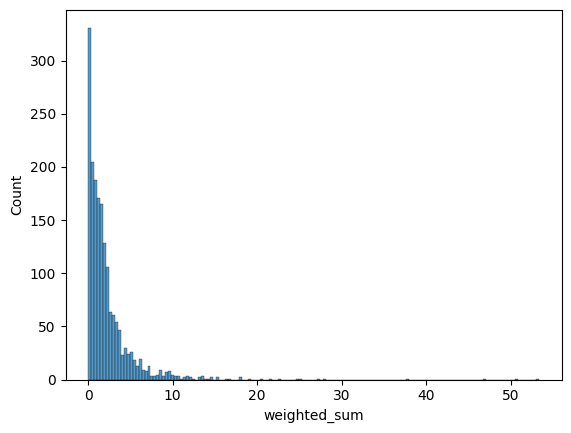

In [18]:
import seaborn as sns


sns.histplot(geneWeightedsumDf.weighted_sum)

## Top genes based on the weighted sum

In [19]:
geneWeightedsumDf.sort_values(by=['weighted_sum'], ascending=False)[:20]

,gene,weighted_sum
363,essc,53.386270
358,esad,50.876464
487,gltb,46.922011
445,ftsk,37.587255
114,bglg,28.027139
359,esae,27.382075
706,lys2b,25.063095
357,esac,24.748311
330,ebh,22.504625
1050,ptsg,21.585067


## Create gene-type lookup table from amrfinderplus annotations

In [20]:
import os

import pandas as pd

from pathlib import Path


amrfinderDir = Path(os.environ['GENOMICS_DATA_BASE'], 'amrfinder')

amrfinderDfList = []
for amrfinderFile in os.listdir(amrfinderDir):
    amrfinderDf = pd.read_csv(Path(amrfinderDir, amrfinderFile), sep='\t')
    amrfinderDfList.append(amrfinderDf)

allAmrfinderDf = pd.concat(amrfinderDfList, ignore_index=True)
allAmrfinderDf

/tmp/ipykernel_5561/536070399.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  allAmrfinderDf = pd.concat(amrfinderDfList, ignore_index=True)


,Protein identifier,Contig id,Start,Stop,Strand,Gene symbol,Sequence name,Scope,Element type,Element subtype,Class,Subclass,Method,Target length,Reference sequence length,% Coverage of reference sequence,% Identity to reference sequence,Alignment length,Accession of closest sequence,Name of closest sequence,HMM id,HMM description
0,NaN,1,83926,85452,-,aur,zinc metalloproteinase aureolysin,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,509,509,100.00,99.41,509,EHO93748.1,zinc metalloproteinase aureolysin,NaN,NaN
1,NaN,1,128415,129464,+,icaC,polysaccharide intercellular adhesin biosynthesis/export protein IcaC,plus,VIRULENCE,VIRULENCE,NaN,NaN,EXACTX,350,350,100.00,100.00,350,AUU58561.1,polysaccharide intercellular adhesin biosynthesis/export protein IcaC,NaN,NaN
2,NaN,1,150950,154498,-,cna,collagen adhesin Cna,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,1183,1183,100.00,98.31,1183,BAB96477.1,collagen adhesin Cna,NaN,NaN
3,NaN,1,277464,278813,+,tet(38),tetracycline efflux MFS transporter Tet(38),core,AMR,AMR,TETRACYCLINE,TETRACYCLINE,EXACTX,450,450,100.00,100.00,450,WP_001100300.1,tetracycline efflux MFS transporter Tet(38),NaN,NaN
4,NaN,1,505300,506652,+,mepA,multidrug efflux MATE transporter MepA,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,451,451,100.00,99.33,451,BAB41547.1,multidrug efflux MATE transporter MepA,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57610,NaN,17,83399,84580,-,emrD,multidrug efflux MFS transporter EmrD,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,394,394,100.00,99.24,394,ACN65732.1,multidrug efflux MFS transporter EmrD,NaN,NaN
57611,NaN,2,213498,214724,-,kdeA,multidrug efflux MFS transporter KdeA,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,409,410,99.76,99.02,409,ABR76310.1,multidrug efflux MFS transporter KdeA,NaN,NaN
57612,NaN,3,59710,60882,+,oqxA,multidrug efflux RND transporter periplasmic adaptor subunit OqxA,core,AMR,AMR,PHENICOL/QUINOLONE,PHENICOL/QUINOLONE,BLASTX,391,391,100.00,99.23,391,WP_002914189.1,multidrug efflux RND transporter periplasmic adaptor subunit OqxA,NaN,NaN
57613,NaN,3,60909,64058,+,oqxB9,multidrug efflux RND transporter permease subunit OqxB9,core,AMR,AMR,PHENICOL/QUINOLONE,PHENICOL/QUINOLONE,ALLELEX,1050,1050,100.00,100.00,1050,WP_012967412.1,multidrug efflux RND transporter permease subunit OqxB9,NaN,NaN


In [21]:
genetypeLookupDf = allAmrfinderDf[['Gene symbol', 'Element type']].drop_duplicates()
genetypeLookupDf['Gene symbol'] = genetypeLookupDf['Gene symbol'].str.lower()
genetypeLookupDf

,Gene symbol,Element type
0,aur,VIRULENCE
1,icac,VIRULENCE
2,cna,VIRULENCE
3,tet(38),AMR
4,mepa,AMR
...,...,...
55837,blapdc-58,AMR
56358,blaact-49,AMR
56951,blandm-4,AMR
56963,aac(6')-ib-cr,AMR


## Read vfdb info

In [22]:
import os
import pandas as pd
from pathlib import Path


vfdbInfoFile = Path(os.environ['GENOMICS_DATA_BASE'], 'misc', 'VFDB_info.csv')
vfdbInfoDf = pd.read_csv(vfdbInfoFile)
vfdbInfoDf['Label'] = vfdbInfoDf['Label'].str.lower()
vfdbInfoDf

,Column,ID,Label,Description,Source,Class
0,1,c0393,vat,hemoglobin protease,Escherichia coli O6:K2:H1 CFT073 (UPEC),Autotransporters
1,2,APECO1_O1CoBM73,tsh,Tsh,Escherichia coli O1:K1:H7 (APEC),Autotransporters
2,3,Q673F0_ECOLX,rpea,putative SPATE autotransporter; similar to the SPATE proteins,Escherichia coli plasmid pRAP strain REPEC 83/39,Autotransporters
3,4,ECSF_4010,ecsf_4010,phage protein,Escherichia coli SE15,Autotransporters
4,5,EcSMS35_3921,ecsms35_3921,outer membrane autotransporter,Escherichia coli SMS-3-5 (environmental),Autotransporters
...,...,...,...,...,...,...
249,250,c5077,yddo,ABC transporter ATP-binding protein,Escherichia coli O6:K2:H1 CFT073 (UPEC),UPEC specific genes
250,251,c5078,c5078,oligopeptide ABC transporter,Escherichia coli O6:K2:H1 CFT073 (UPEC),UPEC specific genes
251,252,c5079,yddq,ABC transporter permease,Escherichia coli O6:K2:H1 CFT073 (UPEC),UPEC specific genes
252,253,c5080,yddr,ABC transporter permease,Escherichia coli O6:K2:H1 CFT073 (UPEC),UPEC specific genes


## Read vf collection

In [23]:
import os
import pandas as pd
from pathlib import Path


vfCollectionDescriptionFile = Path(os.environ['GENOMICS_DATA_BASE'], 'misc', 'ecoli_VF_collection_description.tsv')
vfCollectionDescriptionDf = pd.read_csv(vfCollectionDescriptionFile, sep='\t')
vfCollectionDescriptionDf['gene'] = vfCollectionDescriptionDf['gene'].str.lower()
vfCollectionDescriptionDf

,gene,locus tag,accession number (protein_id),description,reference,source,class
0,aap,EC042_pAA055,NaN,dispersin,Escherichia coli O44:H18 042 plasmid pAA (EAEC),VFDB R2,Adhesion_invasion
1,aata,EC042_pAA008,NaN,dispersin secretion locus ABC transporter,Escherichia coli O44:H18 042 plasmid pAA (EAEC),VFDB R2,Adhesion_invasion
2,aatb,EC042_pAA009,NaN,dispersin secretion locus ABC transporter,Escherichia coli O44:H18 042 plasmid pAA (EAEC),VFDB R2,Adhesion_invasion
3,aatc,EC042_pAA010,NaN,dispersin secretion locus ABC transporter,Escherichia coli O44:H18 042 plasmid pAA (EAEC),VFDB R2,Adhesion_invasion
4,aatd,EC042_pAA011,NaN,dispersin secretion locus ABC transporter,Escherichia coli O44:H18 042 plasmid pAA (EAEC),VFDB R2,Adhesion_invasion
...,...,...,...,...,...,...,...
1064,lngj,NaN,ABU50049,"longus pili, coli surface antigen CS20",Escherichia coli O8:H9 E9034A (ETEC),VFDB R3,Type_4_pilus
1065,lngp,NaN,ABU50050,"longus pili, coli surface antigen CS20",Escherichia coli O8:H9 E9034A (ETEC),VFDB R3,Type_4_pilus
1066,etsa,APECO1_O1CoBM197,YP_001481352,ABC transporter,Escherichia coli O1:K1:H7 APEC O1 plasmid pAPEC-O1-ColBM (APEC),manually,Other_virulence_gene
1067,etsb,APECO1_O1CoBM198,YP_001481353,ABC transporter,Escherichia coli O1:K1:H7 APEC O1 plasmid pAPEC-O1-ColBM (APEC),manually,Other_virulence_gene


## Read ABRicate

In [24]:
import os
import pandas as pd
from pathlib import Path


abricateFile = Path(os.environ['GENOMICS_DATA_BASE'], 'misc', 'ABRicate.csv')
abricateDf = pd.read_csv(abricateFile)
abricateDf['gene'] = abricateDf['gene'].str.lower()
abricateDf

,gene,type
0,aaa23990,heat-stable enterotoxin
1,aaa24093,heat labile enterotoxin type IIa A
2,aaa24094,heat labile enterotoxin type IIa B
3,apeco1_1753,hypothetical protein
4,apeco1_1761,hypothetical protein
...,...,...
2696,ygeh,transcriptional regulator
2697,yggr,
2698,yghg,
2699,yijp,


## Add gene descriptions to the top genes

In [25]:
geneWeightedsumDf.sort_values(by=['weighted_sum'], ascending=False)[:20].merge(
    highscoreTokenOverlapsDf[['gene', 'name']].drop_duplicates(),
    on=['gene'],
    how='inner'
).merge(
    genetypeLookupDf,
    left_on=['gene'],
    right_on=['Gene symbol'],
    how='left'
).rename(
    columns={'Element type': 'AMR Finder Type'}
).merge(
    vfdbInfoDf,
    left_on=['gene'],
    right_on=['Label'],
    how='left'
).rename(
    columns={'Class': 'VFDB Type'}
).merge(
    vfCollectionDescriptionDf,
    on=['gene'],
    how='left'
).rename(
    columns={'class': 'VF Collection Type'}
)[['gene', 'name', 'weighted_sum', 'AMR Finder Type', 'VFDB Type', 'VF Collection Type']].drop_duplicates()

,gene,name,weighted_sum,AMR Finder Type,VFDB Type,VF Collection Type
0,essc,type VII secretion system protein EssC%2C FtsK/SpoIIIE family ATPase,53.386270,NaN,NaN,NaN
1,essc,type VII secretion protein EssC,53.386270,NaN,NaN,NaN
2,esad,type VII secretion system secreted protein%2C a nuclease toxin EsaD,50.876464,NaN,NaN,NaN
3,gltb,glutamate synthase large subunit,46.922011,NaN,NaN,NaN
4,ftsk,DNA segregation ATPase FtsK/SpoIIIE or related protein,37.587255,NaN,NaN,NaN
5,ftsk,DNA translocase FtsK,37.587255,NaN,NaN,NaN
6,bglg,Transcriptional antiterminator,28.027139,NaN,NaN,NaN
7,bglg,BglG family transcription antiterminator,28.027139,NaN,NaN,NaN
8,esae,type VII secretion system chaperone protein,27.382075,NaN,NaN,NaN
9,lys2b,Thioester reductase domain of alpha aminoadipate reductase Lys2 and NRPSs,25.063095,NaN,NaN,NaN


## Save all gene hits

In [26]:
import os
import pandas as pd
from pathlib import Path


outputFile = Path(os.environ['GENOMICS_DATA_BASE'], 'temp', 'saur_top_genes_all_overlaping_3sd_tokens.csv')
geneWeightedsumDf.sort_values(by=['weighted_sum'], ascending=False).merge(
    highscoreTokenOverlapsDf[['gene', 'name']].drop_duplicates(),
    on=['gene'],
    how='inner'
).merge(
    genetypeLookupDf,
    left_on=['gene'],
    right_on=['Gene symbol'],
    how='left'
).rename(
    columns={'Element type': 'AMR Finder Type'}
).merge(
    vfdbInfoDf,
    left_on=['gene'],
    right_on=['Label'],
    how='left'
).rename(
    columns={'Class': 'VFDB Type'}
).merge(
    vfCollectionDescriptionDf,
    on=['gene'],
    how='left'
).rename(
    columns={'class': 'VF Collection Type'}
)[['gene', 'name', 'weighted_sum', 'AMR Finder Type', 'VFDB Type', 'VF Collection Type']].drop_duplicates().to_csv(outputFile, index=False)

## Read mapping information

In [27]:
import os

import pandas as pd


demoTrainDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240614/data/wb_365_wa_1/splits_v1/demographics/mortality_normal_train.csv', sep='\t')
demoTestDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240614/data/wb_365_wa_1/splits_v1/demographics/mortality_normal_test.csv', sep='\t')
demoValidateDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240614/data/wb_365_wa_1/splits_v1/demographics/mortality_normal_validate.csv', sep='\t')
demoDf = pd.concat([demoTrainDf, demoTestDf, demoValidateDf], ignore_index=True)
demoDf

,person_id,visit_occurrence_id,TYPE,COUNTRY_OF_BIRTH,SEX,Age_Bin,JOURNEY_ID
0,678487,3312694,Emergency,Australia,Male,"(60, 70]",3312694
1,2094045,9199249,Emergency,Australia,Male,"(20, 30]",9199249
2,2107813,9410987,Emergency,Australia,Male,"(50, 60]",9410987
3,2083212,602890,Inpatient,Australia,Female,"(40, 50]",9039437
4,2083212,9039437,Emergency,Australia,Female,"(40, 50]",9039437
...,...,...,...,...,...,...,...
7194,2603535,16588204,Inpatient,Australia,Male,"(60, 70]",16588204
7195,2603535,16709341,Inpatient,Australia,Male,"(60, 70]",16709341
7196,2603535,16651755,Inpatient,Australia,Male,"(60, 70]",16651755
7197,2098616,16872774,Emergency,Australia,Female,"(80, 90]",16872774


In [28]:
import os

mappingDf = pd.read_csv(os.environ['GENOMICS_DATA_BASE'] + '/patient_tube_id_mapping_full.tsv', sep='\t')
mappingDf

,tube_code,PATIENT_ID,db_ID,pt_age,pt_gender,EPISODE_ID,hospital_admission,hospital_discharge,hospital_in_last_year,genome_species,species_reported,contig_number,length,tube_code_duplicate_or_old,date_of_collection,ID_number,location_additional_02,collected_from_original
0,AH19J072,213972.0,3JNQS,64,Male,12931474.0,2019-10-17,2019-11-29,yes,Escherichia coli,Escherichia coli,92,5131021,NaN,2019-10-30,19-303-0997,A-7EA;HAEM,Blood
1,AH19J074,213972.0,3JNQS,64,Male,12931474.0,2019-10-17,2019-11-29,yes,Streptococcus sp. D19,Streptococcus mitis group,84,2022991,NaN,2019-10-30,19-303-1174,A-7EA;HAEM,Blood Peripheral
2,AH19B003,526238.0,567AE,85,Male,640261.0,2019-02-04,2019-02-07,no,Escherichia coli,Escherichia coli,93,4942915,NaN,2019-02-03,19-034-1596,A-4WB;GMC,Blood
3,AH20A024,788941.0,3YBDS,58,Female,13194824.0,2020-01-16,2020-01-19,no,Escherichia coli,Escherichia coli,110,5149157,NaN,2020-01-16,20-016-2112,S-ED;Emergency,Blood Venous
4,AH20L041,1023735.0,2VJ78,42,Male,14210147.0,2020-12-18,2021-01-05,yes,Staphylococcus aureus,Staphylococcus aureus,46,2735216,NaN,2020-12-16,20-351-2856,Emergency Dept;nan,Blood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3112,ALF22L076,639020.0,3S6HL,84,Male,17219899.0,2022-12-15,2022-12-20,yes,Streptococcus vestibularis,Streptococcus salivarius group,107,1938627,NaN,2022-12-15,22-349-2150,Ward 4WB,Blood Peripheral
3113,ALF22L089,655404.0,6EWBM,67,Female,NaN,NaN,NaN,NaN,Proteus columbae,Proteus vulgaris,152,3972219,NaN,2022-12-17,22-351-1465,Comm/Amb Clinic,Blood
3114,ALF22L138,2572048.0,YM5PJ,61,Male,NaN,NaN,NaN,NaN,Enterobacter roggenkampii,Enterobacter cloacae complex,66,4876179,NaN,2022-12-27,22-361-0202,Ward 7 East,Hick White Lum
3115,ALF23A102,2054964.0,5DYAH,35,Female,17294287.0,2023-01-12,2023-02-01,yes,Streptococcus constellatus,Streptococcus anginosus group,54,1869828,NaN,2023-01-11,23-011-3305,ICU,Blood Venous


In [29]:
mappedJourneyTubeIdsDf = mappingDf[['tube_code', 'PATIENT_ID', 'EPISODE_ID']].drop_duplicates().merge(
    demoDf[['person_id', 'visit_occurrence_id', 'JOURNEY_ID']],
    how='inner',
    left_on=['PATIENT_ID', 'EPISODE_ID'],
    right_on=['person_id', 'visit_occurrence_id']
).drop(
    columns=['PATIENT_ID', 'EPISODE_ID', 'visit_occurrence_id']
)[['person_id', 'JOURNEY_ID', 'tube_code']].drop_duplicates()
mappedJourneyTubeIdsDf

,person_id,JOURNEY_ID,tube_code
0,50056,13224842,AH20B011
1,62567,12645629,AH19G065
2,138108,14737781,AH21E052
3,211314,13955099,AH20J009
4,211314,13955099,KPN2214
...,...,...,...
512,2084373,16158768,ALF22C004
513,1058066,16759482,ALF22H089
514,2552781,16966609,ALF22J054
515,2638484,16969999,ALF22K143


## Read mortality labels

In [30]:
import os

import pandas as pd

from pathlib import Path


mortalityTrainDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240614', 'data', 'wb_365_wa_3', 'splits_v1', 'labels', 'mortality', 'mortality_7_day_normal_train.csv'), sep='\t')
mortalityTestDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240614', 'data', 'wb_365_wa_3', 'splits_v1', 'labels', 'mortality', 'mortality_7_day_normal_test.csv'), sep='\t')
mortalityValidateDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240614', 'data', 'wb_365_wa_3', 'splits_v1', 'labels', 'mortality', 'mortality_7_day_normal_validate.csv'), sep='\t')
mortality7Df = pd.concat([mortalityTrainDf, mortalityTestDf, mortalityValidateDf], ignore_index=True).drop_duplicates()
mortality7Df

,person_id,JOURNEY_ID,visit_occurrence_id,death_7_day
0,678487,3312694,3312694,0
1,2094045,9199249,9199249,0
4,2107813,9410987,9410987,1
8,2083212,9039515,9039515,0
9,2083212,9039437,602890,0
...,...,...,...,...
34962,2603535,16709341,16709341,0
34963,2603535,16651755,16651755,0
34970,2603535,16588204,16588204,0
34984,2098616,16872774,16872774,0


In [31]:
import os

import pandas as pd

from pathlib import Path


mortalityTrainDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240614', 'data', 'wb_365_wa_3', 'splits_v1', 'labels', 'mortality', 'mortality_30_day_normal_train.csv'), sep='\t')
mortalityTestDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240614', 'data', 'wb_365_wa_3', 'splits_v1', 'labels', 'mortality', 'mortality_30_day_normal_test.csv'), sep='\t')
mortalityValidateDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240614', 'data', 'wb_365_wa_3', 'splits_v1', 'labels', 'mortality', 'mortality_30_day_normal_validate.csv'), sep='\t')
mortality30Df = pd.concat([mortalityTrainDf, mortalityTestDf, mortalityValidateDf], ignore_index=True).drop_duplicates()
mortality30Df

,person_id,JOURNEY_ID,visit_occurrence_id,death_30_day
0,678487,3312694,3312694,0
1,2094045,9199249,9199249,0
4,2107813,9410987,9410987,1
8,2083212,9039515,9039515,0
9,2083212,9039437,602890,0
...,...,...,...,...
34962,2603535,16709341,16709341,0
34963,2603535,16651755,16651755,0
34970,2603535,16588204,16588204,0
34984,2098616,16872774,16872774,0


In [32]:
import pandas as pd


mortalityDf = mortality7Df.merge(
    mortality30Df,
    how='inner',
    on=['person_id', 'JOURNEY_ID', 'visit_occurrence_id']
)
# mortalityDf = mortality30Df
mortalityDf

,person_id,JOURNEY_ID,visit_occurrence_id,death_7_day,death_30_day
0,678487,3312694,3312694,0,0
1,2094045,9199249,9199249,0,0
2,2107813,9410987,9410987,1,1
3,2083212,9039515,9039515,0,0
4,2083212,9039437,602890,0,0
...,...,...,...,...,...
7290,2603535,16709341,16709341,0,0
7291,2603535,16651755,16651755,0,0
7292,2603535,16588204,16588204,0,0
7293,2098616,16872774,16872774,0,0


## Create annotations data matrix

In [33]:
geneWeightedsumDf

,gene,weighted_sum
0,5_ureb_srna,0.061550
1,6s,1.498754
2,aaa,1.831435
3,abc-f,0.742134
4,abcc,0.076475
...,...,...
1781,zapa,1.286040
1782,znua,9.320601
1783,znub,4.685461
1784,znuc,3.138582


In [34]:
signatureAnnotationsDf = highscoreTokenOverlapsDf[highscoreTokenOverlapsDf['gene'].isin(geneWeightedsumDf.sort_values(by=['weighted_sum'], ascending=False)[:20]['gene'])]
signatureAnnotationsDf


,contig_id,start_position,end_position,tokens,score,gene,name,tube_code
51,1,104059,104064,GATGTG,0.027761,ccma,ABC-type multidrug transport system%2C ATPase component,AH20I016
52,1,104122,104128,AAAATGG,0.014966,ccma,ABC-type multidrug transport system%2C ATPase component,AH20I016
53,1,104373,104377,TTTGT,0.016255,ccma,ABC-type multidrug transport system%2C ATPase component,AH20I016
54,1,104463,104469,CCAACAT,0.020258,ccma,ABC-type multidrug transport system%2C ATPase component,AH20I016
55,1,104625,104630,AATGAT,0.014629,ccma,ABC-type multidrug transport system%2C ATPase component,AH20I016
...,...,...,...,...,...,...,...,...
281259,1,358534,358539,TAAAGG,0.013273,tet(38),tetracycline efflux MFS transporter Tet(38),AH21A011
281260,1,358734,358737,AACC,0.015188,tet(38),tetracycline efflux MFS transporter Tet(38),AH21A011
281261,1,358845,358851,CTATAAA,0.016098,tet(38),tetracycline efflux MFS transporter Tet(38),AH21A011
281262,1,358993,358997,CATGA,0.013797,tet(38),tetracycline efflux MFS transporter Tet(38),AH21A011


In [35]:
signatureDataDf = signatureAnnotationsDf[['tube_code', 'gene']].drop_duplicates()
# Get one hot encoding of columns B
one_hot = pd.get_dummies(signatureDataDf['gene'])
# Drop column B as it is now encoded
signatureDataDf = signatureDataDf.drop('gene',axis = 1)
# Join the encoded df
signatureDataDf = signatureDataDf.join(one_hot)
signatureDataDf = signatureDataDf.loc[:, (signatureDataDf != 0).any(axis=0)]
signatureDataDf = signatureDataDf*1
signatureDataDf

,tube_code,acoa,acob,araj,bglg,ccma,ebh,esac,esad,esae,essc,fadb,ftsk,gltb,lys2b,lysr,polc,ptsg,qri1,sbcc,tet(38)
51,AH20I016,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
102,AH20I016,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
207,AH20I016,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
214,AH20I016,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
588,AH20I016,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279530,ALF22J050,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
279644,ALF23C003,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
279887,ALF23C094,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
279920,AH20H052,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


### Create datamatrix

In [36]:
dataDf = mortalityDf.merge(
    mappedJourneyTubeIdsDf,
    on=['person_id', 'JOURNEY_ID'],
    how='inner'
).drop(
    columns=['visit_occurrence_id']
).drop_duplicates().merge(
    signatureDataDf,
    on=['tube_code'],
    how='left'
).drop(
    columns=['tube_code']
)
dataDf = dataDf.fillna(0)
dataDf = dataDf.loc[:, (dataDf != 0).any(axis=0)]
dataDf

,person_id,JOURNEY_ID,death_7_day,death_30_day,acoa,acob,araj,bglg,ccma,ebh,esac,esad,esae,essc,fadb,ftsk,gltb,lys2b,lysr,polc,ptsg,qri1,sbcc,tet(38)
0,2154700,10220218,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2145022,601149,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2145022,601149,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2145022,601149,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2145022,601149,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678,1058066,16759482,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
679,2450777,16762608,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
680,869203,16808421,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
681,2202513,16816295,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Calculate correlation

In [37]:
dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr().sort_values('death_30_day', ascending=False)

,death_7_day,death_30_day,acoa,acob,araj,bglg,ccma,ebh,esac,esad,esae,essc,fadb,ftsk,gltb,lys2b,lysr,polc,ptsg,qri1,sbcc,tet(38)
death_30_day,0.559265,1.000000,0.004504,0.004504,0.020628,-0.009135,-0.023206,-0.020118,-0.013248,0.014668,0.014668,-0.049516,0.006389,0.010193,0.038953,0.005378,-0.053326,-0.065770,0.051754,-0.046334,0.035864,0.014466
death_7_day,1.000000,0.559265,0.046219,0.046219,0.034900,-0.009096,0.017708,0.021856,-0.028407,-0.030706,-0.030706,-0.042032,-0.032851,-0.021010,0.065557,0.007588,-0.006291,-0.036783,0.073189,-0.025913,0.036188,0.045503
ptsg,0.073189,0.051754,-0.013331,-0.013331,-0.031686,-0.026026,-0.035910,-0.017674,-0.016351,-0.017674,-0.017674,-0.024193,-0.018908,-0.030166,-0.018908,-0.030934,-0.025125,-0.021171,1.000000,-0.014915,-0.014915,-0.022221
gltb,0.065557,0.038953,-0.008356,-0.008356,-0.019861,-0.016314,-0.022509,-0.011078,-0.010249,-0.011078,-0.011078,-0.015164,-0.011852,-0.018908,1.000000,-0.019390,-0.015749,-0.013270,-0.018908,-0.009349,-0.009349,-0.013929
sbcc,0.036188,0.035864,-0.006591,-0.006591,-0.015667,-0.012868,-0.017755,-0.008739,-0.008084,-0.008739,-0.008739,-0.011962,-0.009349,-0.014915,-0.009349,-0.015295,-0.012423,-0.010468,-0.014915,-0.007375,1.000000,-0.010987
araj,0.034900,0.020628,-0.014003,-0.014003,1.000000,-0.027338,-0.037720,-0.018565,-0.017175,-0.018565,-0.018565,-0.025412,-0.019861,-0.031686,-0.019861,-0.032493,-0.026391,-0.022238,-0.031686,-0.015667,-0.015667,-0.023341
esad,-0.030706,0.014668,-0.007810,-0.007810,-0.018565,-0.015249,-0.021039,-0.010355,-0.009580,1.000000,-0.010355,-0.014175,-0.011078,-0.017674,-0.011078,-0.018124,-0.014721,-0.012404,-0.017674,-0.008739,-0.008739,-0.013019
esae,-0.030706,0.014668,-0.007810,-0.007810,-0.018565,-0.015249,-0.021039,-0.010355,-0.009580,-0.010355,1.000000,-0.014175,-0.011078,-0.017674,-0.011078,-0.018124,-0.014721,-0.012404,-0.017674,-0.008739,-0.008739,-0.013019
tet(38),0.045503,0.014466,-0.009820,-0.009820,-0.023341,-0.019172,-0.026453,-0.013019,-0.012045,-0.013019,-0.013019,-0.017822,-0.013929,-0.022221,-0.013929,-0.022787,-0.018508,-0.015596,-0.022221,-0.010987,-0.010987,1.000000
ftsk,-0.021010,0.010193,-0.013331,-0.013331,-0.031686,-0.026026,-0.035910,-0.017674,-0.016351,-0.017674,-0.017674,-0.024193,-0.018908,1.000000,-0.018908,-0.030934,-0.025125,-0.021171,-0.030166,-0.014915,-0.014915,-0.022221


### Plot correlations as a heatmap

<Axes: >

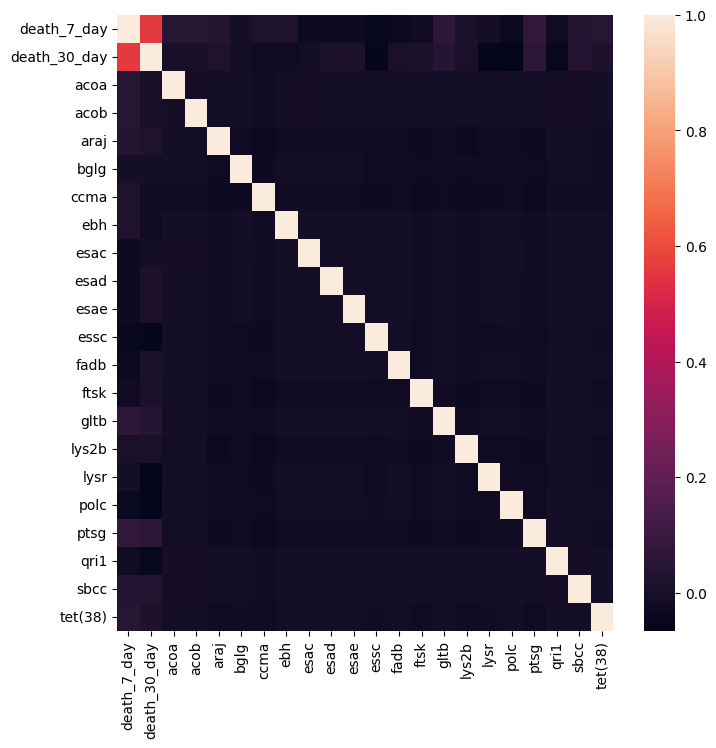

In [38]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.colors import SymLogNorm


f, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the heatmap
sns.heatmap(dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr())

### Plot correlations as a heatmap (Log scale)

<Axes: >

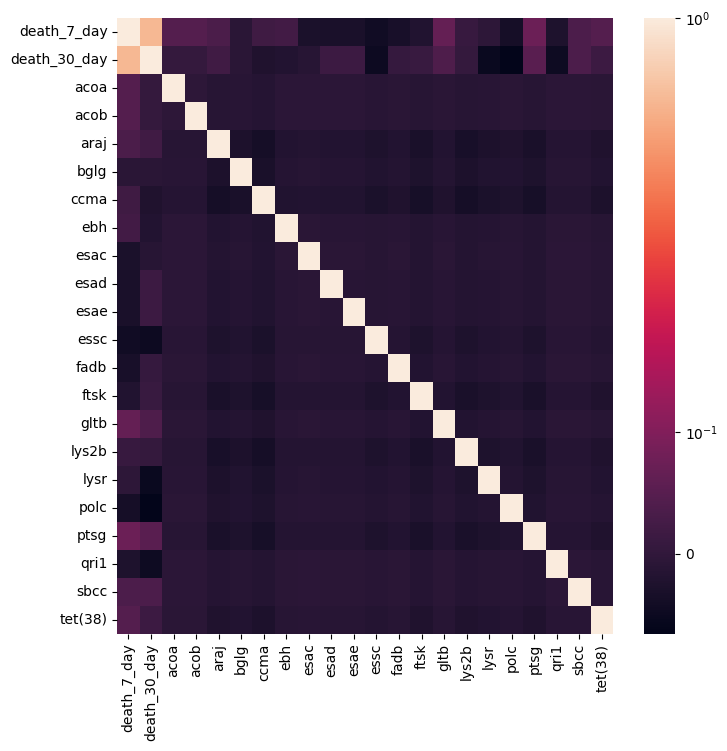

In [39]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.colors import SymLogNorm


f, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the heatmap
sns.heatmap(dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr(), norm=SymLogNorm(linthresh=0.3))

### Plot correlations as a heatmap (Log scale - Sorted)

<Axes: >

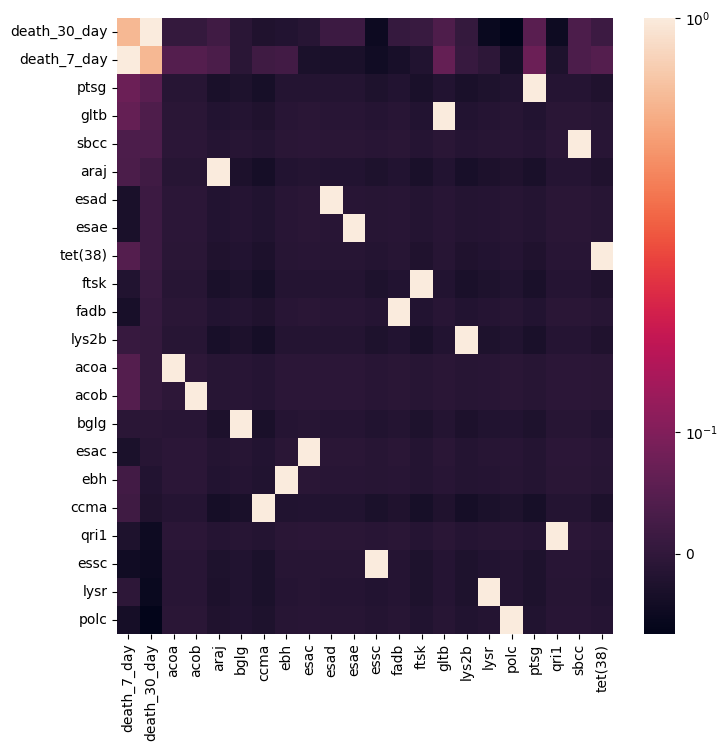

In [40]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.colors import SymLogNorm


f, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the heatmap
sns.heatmap(dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr().sort_values('death_30_day', ascending=False), norm=SymLogNorm(linthresh=0.3))

### Model using machine learning (7 day mortality)

In [41]:
X = dataDf.drop(columns=['person_id', 'JOURNEY_ID', 'death_7_day', 'death_30_day'])
y = dataDf.death_7_day

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Balanced Accuracy: ', balanced_accuracy_score(y_test, y_pred))
print('Average Precision: ', average_precision_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))
print('ROC AUC: ', roc_auc_score(y_test, y_pred))

Accuracy:  0.13138686131386862
Balanced Accuracy:  0.53515625
Average Precision:  0.0703125
F1 Score:  0.13138686131386862
ROC AUC:  0.53515625


In [43]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lrc = LogisticRegression(random_state=0)
y_pred = lrc.fit(X_train, y_train).predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Balanced Accuracy: ', balanced_accuracy_score(y_test, y_pred))
print('Average Precision: ', average_precision_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))
print('ROC AUC: ', roc_auc_score(y_test, y_pred))

Accuracy:  0.9343065693430657
Balanced Accuracy:  0.5
Average Precision:  0.06569343065693431
F1 Score:  0.0
ROC AUC:  0.5


In [44]:
coefficients = lrc.coef_[0]
featureImportanceDf = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
    }).sort_values(by=['Coefficient'])
featureImportanceDf

,Feature,Coefficient
9,essc,-0.551100
15,polc,-0.479922
8,esae,-0.399580
7,esad,-0.355242
10,fadb,-0.307627
6,esac,-0.307627
17,qri1,-0.256269
3,bglg,-0.036194
14,lysr,0.006065
11,ftsk,0.006065


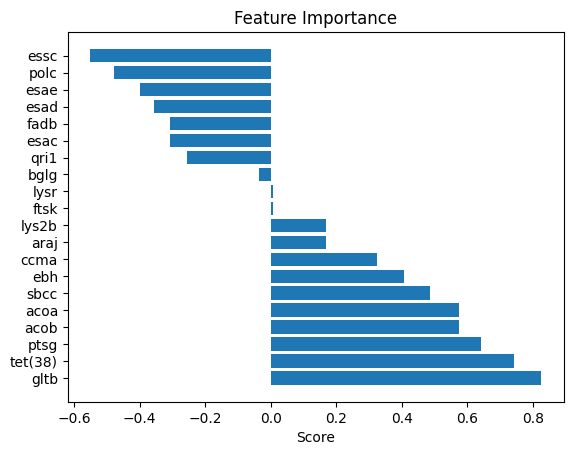

In [45]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()

ax.barh(y=featureImportanceDf.Feature, width=featureImportanceDf.Coefficient, align='center')
# ax.set_yticks(y_pos, labels=people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Score')
ax.set_title('Feature Importance')

plt.show()


### Model using machine learning (30 day mortality)

In [46]:
X = dataDf.drop(columns=['person_id', 'JOURNEY_ID', 'death_7_day', 'death_30_day'])
y = dataDf.death_30_day

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Balanced Accuracy: ', balanced_accuracy_score(y_test, y_pred))
print('Average Precision: ', average_precision_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))
print('ROC AUC: ', roc_auc_score(y_test, y_pred))

Accuracy:  0.24817518248175183
Balanced Accuracy:  0.5066978193146418
Average Precision:  0.22129418101446852
F1 Score:  0.36024844720496896
ROC AUC:  0.5066978193146418


In [48]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lrc = LogisticRegression(random_state=0)
y_pred = lrc.fit(X_train, y_train).predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Balanced Accuracy: ', balanced_accuracy_score(y_test, y_pred))
print('Average Precision: ', average_precision_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))
print('ROC AUC: ', roc_auc_score(y_test, y_pred))

Accuracy:  0.781021897810219
Balanced Accuracy:  0.5
Average Precision:  0.21897810218978103
F1 Score:  0.0
ROC AUC:  0.5


In [49]:
coefficients = lrc.coef_[0]
featureImportanceDf = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
    }).sort_values(by=['Coefficient'])
featureImportanceDf

,Feature,Coefficient
9,essc,-1.044612
15,polc,-0.938835
14,lysr,-0.627570
17,qri1,-0.560428
4,ccma,-0.301172
13,lys2b,-0.077263
6,esac,-0.074560
5,ebh,-0.074560
10,fadb,-0.074560
3,bglg,0.011005


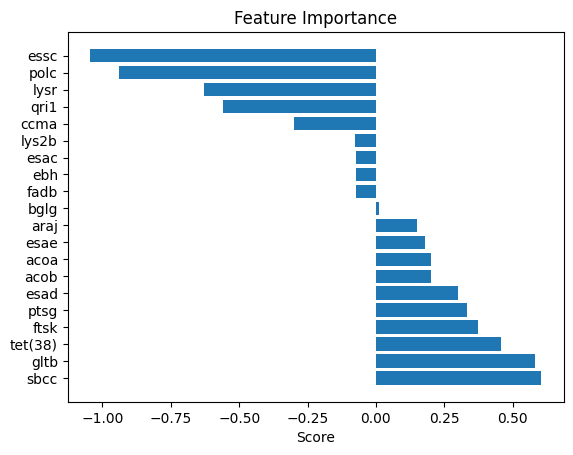

In [50]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()

ax.barh(y=featureImportanceDf.Feature, width=featureImportanceDf.Coefficient, align='center')
# ax.set_yticks(y_pos, labels=people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Score')
ax.set_title('Feature Importance')

plt.show()


## Create tokens data matrix

In [51]:
import numpy as np


tokenWeightedsumDf = highscoreTokenOverlapsDf.groupby(by=['tokens']).agg({'score': np.sum}).reset_index().rename(columns={'score': 'weighted_sum'})
tokenWeightedsumDf

/tmp/ipykernel_5561/457035517.py:4: FutureWarning: The provided callable <function sum at 0x70b668c943a0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  tokenWeightedsumDf = highscoreTokenOverlapsDf.groupby(by=['tokens']).agg({'score': np.sum}).reset_index().rename(columns={'score': 'weighted_sum'})


,tokens,weighted_sum
0,AAAAAA,0.043837
1,AAAAAAA,2.032105
2,AAAAAAT,0.342919
3,AAAAAATTA,0.187351
4,AAAAACAA,1.457375
...,...,...
1454,TTTTGTTTT,0.027434
1455,TTTTTAA,0.671302
1456,TTTTTCA,3.878010
1457,TTTTTCT,0.279267


In [52]:
signatureTokensDf = highscoreTokenOverlapsDf[highscoreTokenOverlapsDf['tokens'].isin(tokenWeightedsumDf.sort_values(by=['weighted_sum'], ascending=False)[:20]['tokens'])]
signatureTokensDf

,contig_id,start_position,end_position,tokens,score,gene,name,tube_code
0,1,212,217,TGATTT,0.016428,acpp,acyl carrier protein,AH20I016
23,1,13080,13084,TTTGT,0.014794,yfho,lipoteichoic acid-specific glycosyltransferase YfhO,AH20I016
30,1,43186,43191,CAATAA,0.015891,rimp,ribosome maturation factor RimP,AH20I016
33,1,44362,44366,CCAGT,0.012659,nusa,Transcription antitermination factor NusA%2C contains S1 and KH domains,AH20I016
38,1,102681,102686,AAACAT,0.013746,cls,cardiolipin synthase,AH20I016
...,...,...,...,...,...,...,...,...
281308,3,312909,312914,TAATTT,0.015043,mepA,multidrug efflux MATE transporter MepA,AH20L076
281313,3,313125,313131,AATGTTT,0.015912,mepA,multidrug efflux MATE transporter MepA,AH20L076
281315,3,313171,313176,CAATTT,0.025049,mepA,multidrug efflux MATE transporter MepA,AH20L076
281318,3,313529,313533,ATGGT,0.019383,mepA,multidrug efflux MATE transporter MepA,AH20L076


In [53]:
signatureDataDf = signatureTokensDf[['tube_code', 'tokens']].drop_duplicates()
# Get one hot encoding of columns B
one_hot = pd.get_dummies(signatureDataDf['tokens'])
# Drop column B as it is now encoded
signatureDataDf = signatureDataDf.drop('tokens',axis = 1)
# Join the encoded df
signatureDataDf = signatureDataDf.join(one_hot)
signatureDataDf = signatureDataDf.loc[:, (signatureDataDf != 0).any(axis=0)]
signatureDataDf = signatureDataDf*1
signatureDataDf


,tube_code,AAAATGT,AAACAT,AACAC,AATGTTT,ATGGT,CAATAA,CAATTT,CACCGT,CATAC,CCAGT,CCTTTT,CTTAC,GAAAG,GGTCT,TAATTT,TGATTT,TTGCAA,TTGTG,TTGTTTA,TTTGT
0,AH20I016,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
23,AH20I016,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
30,AH20I016,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
33,AH20I016,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
38,AH20I016,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281119,ALF23C174,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
281122,ALF23C174,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
281123,ALF23C174,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
281124,ALF23C174,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Create datamatrix

In [54]:
dataDf = mortalityDf.merge(
    mappedJourneyTubeIdsDf,
    on=['person_id', 'JOURNEY_ID'],
    how='inner'
).drop(
    columns=['visit_occurrence_id']
).drop_duplicates().merge(
    signatureDataDf,
    on=['tube_code'],
    how='left'
).drop(
    columns=['tube_code']
)
dataDf = dataDf.fillna(0)
dataDf = dataDf.loc[:, (dataDf != 0).any(axis=0)]
dataDf

,person_id,JOURNEY_ID,death_7_day,death_30_day,AAAATGT,AAACAT,AACAC,AATGTTT,ATGGT,CAATAA,CAATTT,CACCGT,CATAC,CCAGT,CCTTTT,CTTAC,GAAAG,GGTCT,TAATTT,TGATTT,TTGCAA,TTGTG,TTGTTTA,TTTGT
0,2154700,10220218,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2154700,10220218,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2154700,10220218,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2154700,10220218,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2154700,10220218,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,1058066,16759482,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1796,2450777,16762608,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1797,869203,16808421,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1798,2202513,16816295,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Calculate correlation

In [55]:
dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr().sort_values('death_30_day', ascending=False)

,death_7_day,death_30_day,AAAATGT,AAACAT,AACAC,AATGTTT,ATGGT,CAATAA,CAATTT,CACCGT,CATAC,CCAGT,CCTTTT,CTTAC,GAAAG,GGTCT,TAATTT,TGATTT,TTGCAA,TTGTG,TTGTTTA,TTTGT
death_30_day,0.608479,1.000000,0.001676,0.001676,0.003338,0.005023,0.001676,0.005023,0.001676,0.005023,-0.001821,0.001676,0.003338,0.001676,-0.003458,0.008525,0.001676,0.003338,-0.003458,0.001676,0.004971,-0.003458
death_7_day,1.000000,0.608479,0.006373,0.006373,0.007422,0.008486,0.006373,0.008486,0.006373,0.008486,-0.001043,0.006373,0.007422,0.006373,0.007422,0.015225,0.006373,0.007422,-0.002039,0.006373,0.003092,0.007422
GGTCT,0.015225,0.008525,-0.037393,-0.037393,-0.037110,-0.036826,-0.037393,-0.036826,-0.037393,-0.036826,-0.036826,-0.037393,-0.037110,-0.037393,-0.037110,1.000000,-0.037393,-0.037110,-0.037110,-0.037393,-0.035669,-0.037110
CAATAA,0.008486,0.005023,-0.039257,-0.039257,-0.038960,-0.038661,-0.039257,1.000000,-0.039257,-0.038661,-0.038661,-0.039257,-0.038960,-0.039257,-0.038960,-0.036826,-0.039257,-0.038960,-0.038960,-0.039257,-0.037446,-0.038960
AATGTTT,0.008486,0.005023,-0.039257,-0.039257,-0.038960,1.000000,-0.039257,-0.038661,-0.039257,-0.038661,-0.038661,-0.039257,-0.038960,-0.039257,-0.038960,-0.036826,-0.039257,-0.038960,-0.038960,-0.039257,-0.037446,-0.038960
CACCGT,0.008486,0.005023,-0.039257,-0.039257,-0.038960,-0.038661,-0.039257,-0.038661,-0.039257,1.000000,-0.038661,-0.039257,-0.038960,-0.039257,-0.038960,-0.036826,-0.039257,-0.038960,-0.038960,-0.039257,-0.037446,-0.038960
TTGTTTA,0.003092,0.004971,-0.038023,-0.038023,-0.037736,-0.037446,-0.038023,-0.037446,-0.038023,-0.037446,-0.037446,-0.038023,-0.037736,-0.038023,-0.037736,-0.035669,-0.038023,-0.037736,-0.037736,-0.038023,1.000000,-0.037736
AACAC,0.007422,0.003338,-0.039560,-0.039560,1.000000,-0.038960,-0.039560,-0.038960,-0.039560,-0.038960,-0.038960,-0.039560,-0.039261,-0.039560,-0.039261,-0.037110,-0.039560,-0.039261,-0.039261,-0.039560,-0.037736,-0.039261
CCTTTT,0.007422,0.003338,-0.039560,-0.039560,-0.039261,-0.038960,-0.039560,-0.038960,-0.039560,-0.038960,-0.038960,-0.039560,1.000000,-0.039560,-0.039261,-0.037110,-0.039560,-0.039261,-0.039261,-0.039560,-0.037736,-0.039261
TGATTT,0.007422,0.003338,-0.039560,-0.039560,-0.039261,-0.038960,-0.039560,-0.038960,-0.039560,-0.038960,-0.038960,-0.039560,-0.039261,-0.039560,-0.039261,-0.037110,-0.039560,1.000000,-0.039261,-0.039560,-0.037736,-0.039261


### Plot correlations as a heatmap

<Axes: >

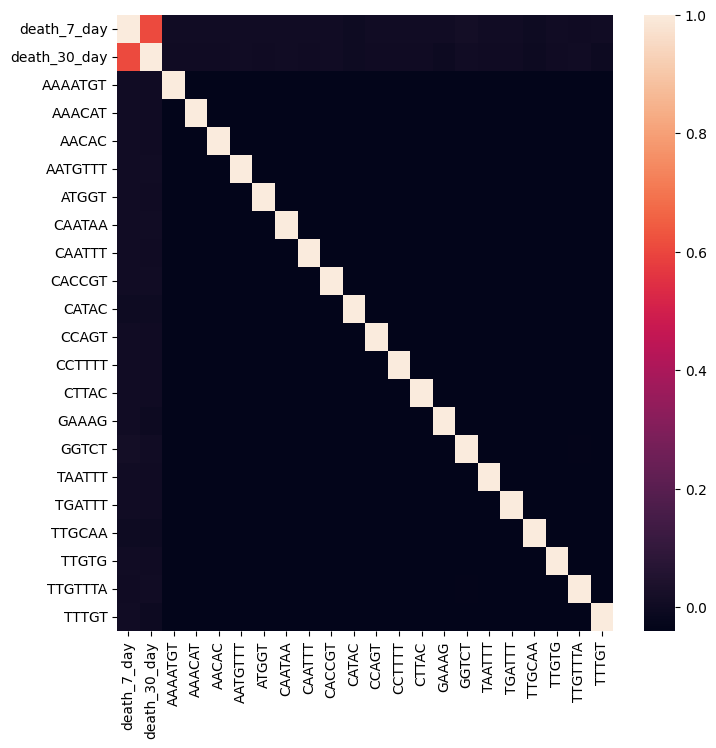

In [56]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.colors import SymLogNorm


f, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the heatmap
sns.heatmap(dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr())

### Plot correlations as a heatmap (Log scale)

<Axes: >

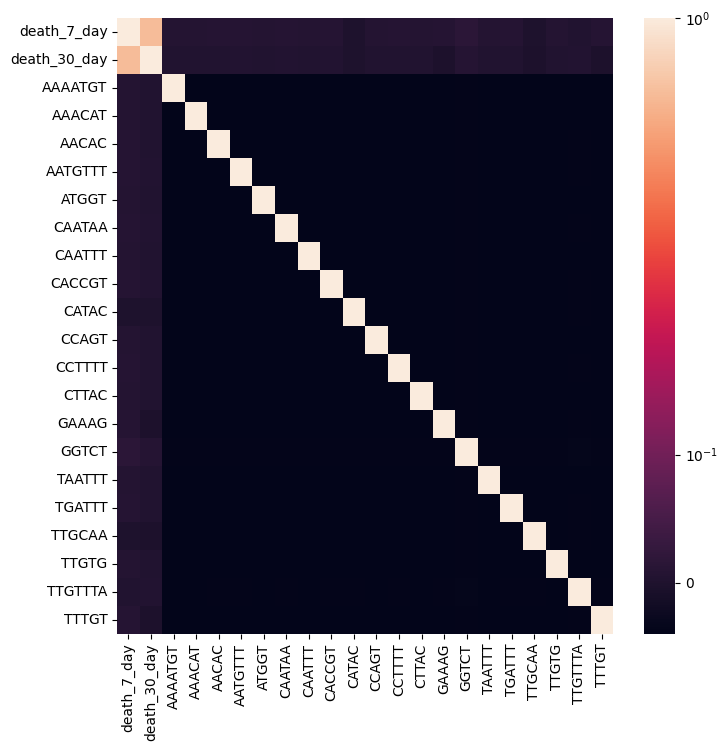

In [57]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.colors import SymLogNorm


f, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the heatmap
sns.heatmap(dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr(), norm=SymLogNorm(linthresh=0.3))

### Plot correlations as a heatmap (Log scale - Sorted)

<Axes: >

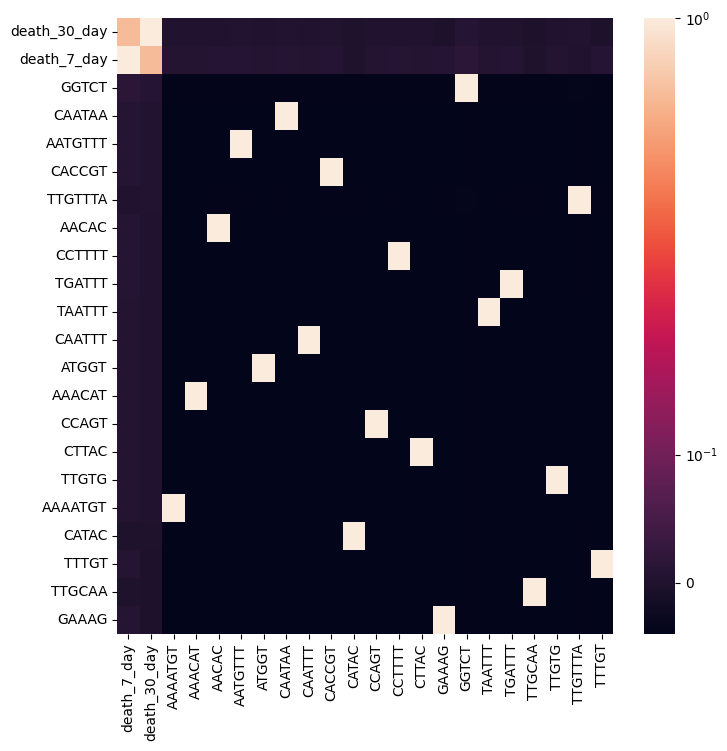

In [58]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.colors import SymLogNorm


f, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the heatmap
sns.heatmap(dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr().sort_values('death_30_day', ascending=False), norm=SymLogNorm(linthresh=0.3))

### Model using machine learning (7 day)

In [59]:
X = dataDf.drop(columns=['person_id', 'JOURNEY_ID', 'death_30_day', 'death_7_day'])
y = dataDf.death_7_day

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Balanced Accuracy: ', balanced_accuracy_score(y_test, y_pred))
print('Average Precision: ', average_precision_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))
print('ROC AUC: ', roc_auc_score(y_test, y_pred))

Accuracy:  0.7055555555555556
Balanced Accuracy:  0.44126984126984126
Average Precision:  0.11904186795491144
F1 Score:  0.07017543859649122
ROC AUC:  0.44126984126984126


In [61]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lrc = LogisticRegression(random_state=0)
y_pred = lrc.fit(X_train, y_train).predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Balanced Accuracy: ', balanced_accuracy_score(y_test, y_pred))
print('Average Precision: ', average_precision_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))
print('ROC AUC: ', roc_auc_score(y_test, y_pred))

Accuracy:  0.875
Balanced Accuracy:  0.5
Average Precision:  0.125
F1 Score:  0.0
ROC AUC:  0.5


In [62]:
coefficients = lrc.coef_[0]
featureImportanceDf = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
    }).sort_values(by=['Coefficient'])
featureImportanceDf

,Feature,Coefficient
4,ATGGT,-0.199472
6,CAATTT,-0.077621
8,CATAC,-0.060824
16,TTGCAA,-0.002678
18,TTGTTTA,0.048974
1,AAACAT,0.179211
17,TTGTG,0.180652
3,AATGTTT,0.195263
5,CAATAA,0.228354
10,CCTTTT,0.245423


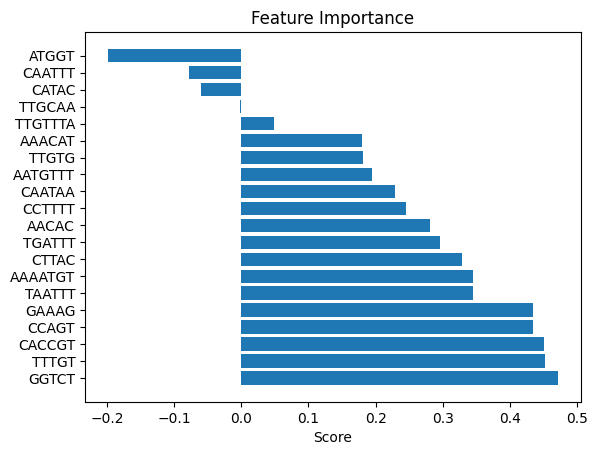

In [63]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()

ax.barh(y=featureImportanceDf.Feature, width=featureImportanceDf.Coefficient, align='center')
# ax.set_yticks(y_pos, labels=people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Score')
ax.set_title('Feature Importance')

plt.show()

### Model using machine learning (30 day)

In [64]:
X = dataDf.drop(columns=['person_id', 'JOURNEY_ID', 'death_30_day', 'death_7_day'])
y = dataDf.death_30_day

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Balanced Accuracy: ', balanced_accuracy_score(y_test, y_pred))
print('Average Precision: ', average_precision_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))
print('ROC AUC: ', roc_auc_score(y_test, y_pred))

Accuracy:  0.6055555555555555
Balanced Accuracy:  0.44814814814814813
Average Precision:  0.23771929824561405
F1 Score:  0.14457831325301204
ROC AUC:  0.44814814814814813


In [66]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lrc = LogisticRegression(random_state=0)
y_pred = lrc.fit(X_train, y_train).predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Balanced Accuracy: ', balanced_accuracy_score(y_test, y_pred))
print('Average Precision: ', average_precision_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))
print('ROC AUC: ', roc_auc_score(y_test, y_pred))

Accuracy:  0.75
Balanced Accuracy:  0.5
Average Precision:  0.25
F1 Score:  0.0
ROC AUC:  0.5


In [67]:
coefficients = lrc.coef_[0]
featureImportanceDf = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
    }).sort_values(by=['Coefficient'])
featureImportanceDf

,Feature,Coefficient
17,TTGTG,-0.128736
6,CAATTT,-0.089954
16,TTGCAA,-0.066677
4,ATGGT,-0.066677
1,AAACAT,-0.046387
0,AAAATGT,-0.025676
2,AACAC,-0.011426
12,GAAAG,-0.011426
7,CACCGT,0.021899
8,CATAC,0.035202


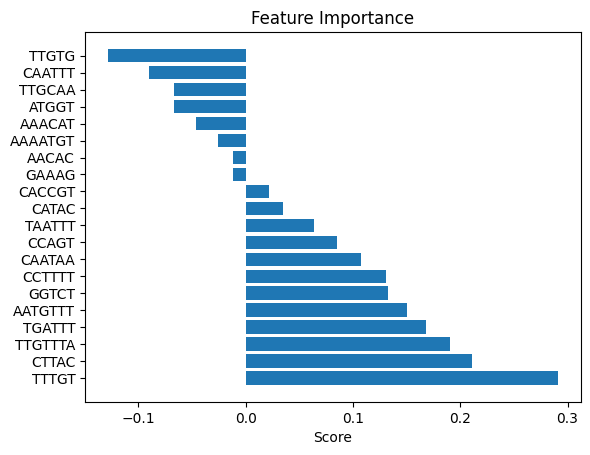

In [68]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()

ax.barh(y=featureImportanceDf.Feature, width=featureImportanceDf.Coefficient, align='center')
# ax.set_yticks(y_pos, labels=people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Score')
ax.set_title('Feature Importance')

plt.show()

### Get genes corresponding to the top tokens

#### Token `TTTGT` (+ve feature importance)

In [73]:
highscoreTokenOverlapsDf[highscoreTokenOverlapsDf.tokens == 'TTTGT'][['gene']].value_counts()[:20]

gene 
pucg     101
trec      82
miab      69
arac      63
ptsg      60
metl1     53
clpb      48
tdcb      39
yehr      38
ebh       38
cvpa      37
znua      36
trmfo     34
accb      34
asps      33
tyrs      32
phet      31
gltp      30
purh      28
pola      27
Name: count, dtype: int64

`pucG`: The pucG gene in Staphylococcus aureus is part of the purine biosynthesis pathway and is essential for the bacteria's ability to synthesize purines.